In [1]:
import os
import tensorflow as tf
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')
BATCH_SIZE = 8

In [2]:
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt,glob
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
import time
from sklearn.model_selection import train_test_split
from scipy.sparse import coo_matrix, csr_matrix
from scipy.spatial.distance import jaccard, cosine 
import pandas as pd
import re

In [3]:
from keras.callbacks import EarlyStopping
from pathlib import Path
import tifffile as tiff
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, GRU, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Masking

In [4]:
from PIL import Image
import shutil

In [38]:
BATCH_SIZE = 4
feats = {"image_name" : tf.io.FixedLenFeature([],tf.string),"image": tf.io.FixedLenFeature([],tf.string),}
def tform_monet_example(example):
    example= tf.io.parse_single_example(example, feats)
    img= tf.image.decode_jpeg(example["image"],channels =3)
    img =tf.image.resize(img,[256,256],method='bicubic')
    img= tf.cast(img, tf.float32) / 127.5 -1
    return img

In [67]:
photo_files = tf.io.gfile.glob("/Users/kevinwalker/Downloads/gan-getting-started-3/photo_tfrec/*.tfrec")
monet_files = tf.io.gfile.glob("/Users/kevinwalker/Downloads/gan-getting-started-3/monet_tfrec/*.tfrec")
photo_data = (tf.data.TFRecordDataset(photo_files).map(tform_monet_example, num_parallel_calls =tf.data.AUTOTUNE).batch(BATCH_SIZE).shuffle(7038,seed=21,reshuffle_each_iteration=True))

monet_data = (tf.data.TFRecordDataset(monet_files).map(tform_monet_example, num_parallel_calls =tf.data.AUTOTUNE).batch(BATCH_SIZE).shuffle(7038,seed=21,reshuffle_each_iteration=True))


2025-11-24 13:54:04.814037: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


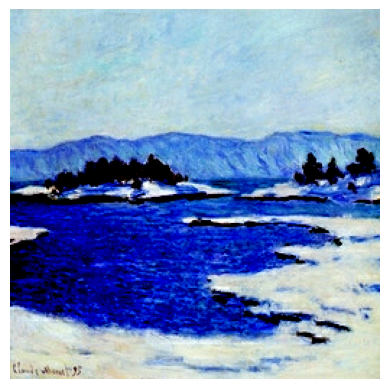

In [68]:
for batch in monet_data.take(40):
    imgP= batch[0]


plt.imshow(imgP)
plt.axis('off')
plt.show()

2025-11-24 13:54:09.195330: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


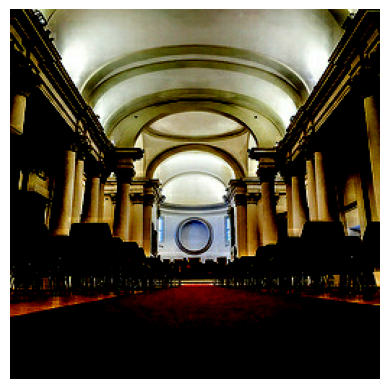

In [69]:
for batch in photo_data.take(40):
    imgP= batch[0]


plt.imshow(imgP)
plt.axis('off')
plt.show()

In [104]:
batch_means=[]
batch_stds =[]
for batch in photo_data:
    batch_means.append(tf.reduce_mean(photo_batch,axis=[0,1,2]))
    batch_stds.append(tf.math.reduce_std(photo_batch,axis=[0,1,2]))

color_mean =  tf.reduce_mean(tf.stack(batch_means,axis=0))
color_std = tf.math.reduce_std(tf.stack(batch_stds,axis=0))

print("photo mean ", color_mean, "photo std ",color_std)

2025-11-24 15:05:15.923063: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


photo mean  tf.Tensor(-0.20073843, shape=(), dtype=float32) photo std  tf.Tensor(0.025107836, shape=(), dtype=float32)


In [105]:
batch_means=[]
batch_stds =[]
for batch in photo_data:
    batch_means.append(tf.reduce_mean(monet_batch,axis=[0,1,2]))
    batch_stds.append(tf.math.reduce_std(monet_batch,axis=[0,1,2]))

color_mean =  tf.reduce_mean(tf.stack(batch_means,axis=0))
color_std = tf.math.reduce_std(tf.stack(batch_stds,axis=0))

print("monet mean ", color_mean, "monet std ",color_std)

monet mean  tf.Tensor(-0.07836852, shape=(), dtype=float32) monet std  tf.Tensor(0.040852003, shape=(), dtype=float32)


2025-11-24 15:06:10.166582: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [70]:
train_dataset = tf.data.Dataset.zip((photo_data,monet_data))
print(train_dataset)

<_ZipDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None))>


Write up 
STEP1 The Problem we are trying to solve is to convert 7k to 10k realistic photos into monet style images.  We have 300 monet style images and 7038 regular photos to convert. They are all 256 x 256 (x3) images. The goal is to use a CycleGan to feed the photos to a genrater to transform the regular photo into a monet sytle photo and then run it through a discrimnator and find the loss(in this case the loss is scored on MiFID) and improve the generator with better outputs to also improve the discrimator.

Step 2 EDA it was very challenging to learn how to imput the the tfrec images once i did and decoding jpegs I made sure they were all 256*256 and scaled them to -1,1 for the tanh used in cycle gan. Since there was heavy imbalance with the data set where we only have 300 monet photos and 7k+ regular i experemented with different batches and shuffling the data.

I printed a number of monet and photo to make sure the they came through clean and not with error.

I also looked at the average pixel intensity and learned that the monet photos are a bit darker then the photos and also a bit higher standard deviation in intensity then the photos.

Step 3 model building: I decided to do a traditional cycle gan. with an encoder/downsampling a resiual block to try and maintain the key features/styles of the monet and then a decoder/upscaling. I chained these together to get 2 Generators to crate image from my generator builds(monet to photo m2p and photo to monet p2m)

I also then built my two discrimators using the ecoders to downsample and compare the accuracy to the photos and monet inputs.

I ran into a lot of issues where the model would return specific colors ie all my images were blue, then gold, so i figured out I had to fix my identity loss function.
i also experiemented and added some smoothing with discrimator loss of monet phots by softening it (*.9) strength to reduce overfitting.

I also tried training with different batch sizes and learning rates. ie 1e4 and 2e4 sizes 64,16,8,4.


Step 4 Results I ran a number of scenarios via kaggle notebook and my jupyter notebook. I scored a 125 on the leaderboard which I attribute to not being able to handle many epochs because of how long it took to run.  My notebook where i ran 20 epochs my training converaged fairly stably and kept making incrimental improvements on the generator loss. it would have been beneficial to keep running more epochs as the improvement did not completely flatten out.

Step 5 Conclusion smaller batch sizes lead to longer epoch runs.  I could have been a little more agressive on learning rate and converaged the model faster without so many epochs and run times. I also could have reduced how many residual blocks and limited the number of steps in an epoch. Since we only had 300 monet images I could have augmented both with some rotations and flips to help generalize the data.

In [71]:
initialize = tf.random_normal_initializer(mean =0 ,stddev=.018)
dropout_values = [.5,.3,.1]
use_bias = False
print(dropout_values[1])

0.3


In [72]:
#Down sampling

def encoder(filters,size,batchnorm=True,use_bias=use_bias):
    
    result_down = tf.keras.Sequential() 
    result_down.add(tf.keras.layers.Conv2D(filters,size, strides=2,padding= 'same',kernel_initializer=initialize,use_bias = use_bias))

    # for first layer its typical to not apply batch norm
    if batchnorm==True:
        result_down.add(layers.BatchNormalization())
    result_down.add(layers.LeakyReLU()) # using leaky relu to not ignor negative values # using relu ignore the negative noise

    return result_down                  

In [73]:
#tranformer to change the style to monet while keeping integrity of content
def residual_block(result_down,filters=256):
    rblock = tf.keras.layers.Conv2D(filters,3,padding='same', kernel_initializer=initialize)(result_down)
    rblock = layers.BatchNormalization()(rblock)
    rblock = layers.ReLU()(rblock)
    rblock = tf.keras.layers.Conv2D(filters,3,padding='same',kernel_initializer=initialize)(rblock)
    rblock = layers.BatchNormalization()(rblock)
    print(rblock.shape)
    return result_down + rblock
    

In [74]:
#UP sampling

def decoder(filters,size,withdrop=True):
    
    result_up = tf.keras.Sequential() 
    result_up.add(tf.keras.layers.Conv2DTranspose(filters,size, strides=2,padding= 'same',kernel_initializer=initialize,use_bias = False))
    result_up.add(layers.BatchNormalization())
    # for first layer its typical to not apply batch norm
    if withdrop==True:
        result_up.add(layers.Dropout(dropout_values[0]))
        print(dropout_values[0])
    result_up.add(layers.ReLU()) # using relu ignore the negative noise upsampling
    return result_up

In [75]:
#UP sampling

def decoder1(filters,size,withdrop=True):
    
    result_up = tf.keras.Sequential() 
    result_up.add(tf.keras.layers.Conv2DTranspose(filters,size, strides=2,padding= 'same',kernel_initializer=initialize,use_bias = False))
    result_up.add(layers.BatchNormalization())
    # for first layer its typical to not apply batch norm
    if withdrop==True:
        result_up.add(layers.Dropout(dropout_values[1]))
        print(dropout_values[0])
    result_up.add(layers.ReLU()) # using relu ignore the negative noise upsampling
    return result_up

In [76]:
def build_generator():
    inp = layers.Input(shape=(256,256,3))
    x = encoder(64,4,batchnorm=True,use_bias=False)(inp)
    x = encoder(128,4,batchnorm=True,use_bias=False)(x)
    x = encoder(256,4,batchnorm=True,use_bias=False)(x)
    for _ in range (9):
         x = residual_block(x,filters=256)
    x = decoder(128,4,withdrop=False)(x)
    x = decoder(64,4,withdrop=False)(x)
    x=decoder(32,4,withdrop=False)(x)
    output= layers.Conv2D(3,7,padding='same',activation='tanh',kernel_initializer=initialize)(x)
    return Model(inputs=inp,outputs=output,name="gen_model")

In [77]:
def build_generator1():
    inp = layers.Input(shape=(256,256,3))
    x = encoder(64,4,batchnorm=True,use_bias=False)(inp)
    x = encoder(128,4,batchnorm=True,use_bias=False)(x)
    x = encoder(256,4,batchnorm=True,use_bias=False)(x)
    for _ in range (9):
         x = residual_block(x,filters=256)
    x = decoder1(128,4,withdrop=False)(x)
    x = decoder1(64,4,withdrop=False)(x)
    x=decoder(32,4,withdrop=False)(x)
    output= layers.Conv2D(3,7,padding='same',activation='tanh',kernel_initializer=initialize)(x)
    return Model(inputs=inp,outputs=output,name="gen_model")

In [78]:
generatorp2m = build_generator()
generatorm2p = build_generator()
generatorp2m1 = build_generator1()
generatorm2p1 = build_generator1()

(None, 32, 32, 256)
(None, 32, 32, 256)
(None, 32, 32, 256)
(None, 32, 32, 256)
(None, 32, 32, 256)
(None, 32, 32, 256)
(None, 32, 32, 256)
(None, 32, 32, 256)
(None, 32, 32, 256)
(None, 32, 32, 256)
(None, 32, 32, 256)
(None, 32, 32, 256)
(None, 32, 32, 256)
(None, 32, 32, 256)
(None, 32, 32, 256)
(None, 32, 32, 256)
(None, 32, 32, 256)
(None, 32, 32, 256)
(None, 32, 32, 256)
(None, 32, 32, 256)
(None, 32, 32, 256)
(None, 32, 32, 256)
(None, 32, 32, 256)
(None, 32, 32, 256)
(None, 32, 32, 256)
(None, 32, 32, 256)
(None, 32, 32, 256)
(None, 32, 32, 256)
(None, 32, 32, 256)
(None, 32, 32, 256)
(None, 32, 32, 256)
(None, 32, 32, 256)
(None, 32, 32, 256)
(None, 32, 32, 256)
(None, 32, 32, 256)
(None, 32, 32, 256)


In [79]:
def discriminator():
    fake_monet = layers.Input(shape=(256, 256, 3),name="fake_monet_batch")
    x = encoder(64,4,batchnorm=False,use_bias=True)(fake_monet)
    x = encoder(128,4,batchnorm=False,use_bias=True)(x)
    x = encoder(256,4,batchnorm=False,use_bias=True)(x)
    x = layers.Conv2D(512,4,strides=1, padding='same',kernel_initializer=initialize)(x)
    output = layers.Conv2D(1,4,strides=1,padding='same',kernel_initializer=initialize)(x)
    return Model(inputs=fake_monet,outputs=output, name="disc_patch")

In [80]:
disc_modelM =discriminator()
disc_modelP = discriminator()

In [81]:
bceloss= tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [82]:
def disc_loss(monet_genL,photo_genL):
    monet_genL = tf.cast(monet_genL, tf.float32)
    photo_genL = tf.cast(photo_genL, tf.float32)
    monet_loss = bceloss(.9* tf.ones_like(monet_genL),monet_genL)
    photo_loss =bceloss(tf.zeros_like(photo_genL),photo_genL)
    return (monet_loss+photo_loss) *.5

In [83]:
def gen_loss(photo_genL):
    photo_genL = tf.cast(photo_genL,tf.float32)
    return bceloss(tf.ones_like(photo_genL),photo_genL)

In [84]:
LAMBDA = 9
def cycle_loss(real,cycled):
    real = tf.cast(real, tf.float32)
    cycled =tf.cast(cycled,tf.float32)
    return LAMBDA* tf.reduce_mean(tf.abs(real-cycled))

In [85]:
def identity_loss(real, same):
    real = tf.cast(real, tf.float32)
    same =tf.cast(same,tf.float32)
    return .5 *tf.reduce_mean(tf.abs(real-same))

In [86]:
g_p2m_optimizer= tf.keras.optimizers.Adam(2e-4,beta_1 = .5)
g_m2p_optimizer= tf.keras.optimizers.Adam(2e-4,beta_1 = .5)
d_m_optimizer= tf.keras.optimizers.Adam(2e-4,beta_1 = .5)
d_p_optimizer= tf.keras.optimizers.Adam(2e-4,beta_1 = .5)

In [87]:
@tf.function
def train_step(photo_batch,monet_batch):
    with tf.GradientTape(persistent=True) as tape:
        fake_monet = generatorp2m(photo_batch,training=True)
        fake_photo = generatorm2p(monet_batch,training=True)
        
        cycled_photo = generatorm2p(fake_monet, training=True)
        cycled_monet = generatorp2m(fake_photo, training=True)
        
        id_photo = generatorm2p(photo_batch,training=True)
        id_monet = generatorp2m(monet_batch, training= True)
        
        disc_real_m = disc_modelM(monet_batch, training=True)
        disc_real_p = disc_modelP(photo_batch,training= True)
        disc_fake_m = disc_modelM(fake_monet,training=True)
        disc_fake_p = disc_modelP(fake_photo,training=True)
        
        #loss functions
        
        #gen adv loss
        gen_p2ml=gen_loss(disc_fake_m)
        gen_m2pl=gen_loss(disc_fake_p)

        #cycle consistancy loss
        cycle_photo_loss= cycle_loss(photo_batch, cycled_photo)
        cycle_monet_loss= cycle_loss(monet_batch, cycled_monet)

        
        #disc loss
        disc_m_l_val= disc_loss(disc_real_m,disc_fake_m)
        disc_p_l_val= disc_loss(disc_real_p, disc_fake_p)
        
        #identity loss
        
        id_loss_p2m=identity_loss(monet_batch,id_monet)
        id_loss_m2p=identity_loss(photo_batch,id_photo)
        
        # total  gen loss funcitons
        total_p2m_g_l = gen_p2ml + cycle_photo_loss  + cycle_monet_loss + id_loss_p2m
        total_m2p_g_l = gen_m2pl + cycle_photo_loss  + cycle_monet_loss + id_loss_m2p
        
    
    #gradients
    
    gen_p2m_gradients = tape.gradient(total_p2m_g_l,generatorp2m.trainable_variables)
    gen_m2p_gradients = tape.gradient(total_m2p_g_l,generatorm2p.trainable_variables)
    
    disc_m_gradients = tape.gradient(disc_m_l_val, disc_modelM.trainable_variables)
    disc_p_gradients = tape.gradient(disc_p_l_val, disc_modelP.trainable_variables)

    g_p2m_optimizer.apply_gradients(zip(gen_p2m_gradients,generatorp2m.trainable_variables))
    g_m2p_optimizer.apply_gradients(zip(gen_m2p_gradients,generatorm2p.trainable_variables))

    d_p_optimizer.apply_gradients(zip(disc_p_gradients,disc_modelP.trainable_variables))
    d_m_optimizer.apply_gradients(zip(disc_m_gradients,disc_modelM.trainable_variables))

    return disc_m_l_val + disc_p_l_val, total_m2p_g_l + total_p2m_g_l
        

In [108]:
epoch_num= 20
#ran with batch size =16

In [24]:
for epoch in range(epoch_num):
    epoch_d_loss = 0
    epoch_g_loss = 0
    batches =0
    for photo_batch, monet_batch in train_dataset:
        dl, gl = train_step(photo_batch, monet_batch)
        epoch_d_loss+=dl
        epoch_g_loss+=gl
        batches +=1
    epoch_d_loss /= batches
    epoch_g_loss /= batches
    print(f'epoch{epoch+1}/{epoch_num} Discriminator Loss: {epoch_d_loss} Generator Loss: {epoch_g_loss}')

2025-11-24 09:24:43.497073: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-11-24 09:33:52.646197: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


epoch1/20 Discriminator Loss: 1.2919013500213623 Generator Loss: 9.8755521774292


2025-11-24 09:41:29.693726: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


epoch2/20 Discriminator Loss: 1.1697787046432495 Generator Loss: 9.485891342163086


2025-11-24 09:49:08.375412: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


epoch3/20 Discriminator Loss: 1.231481909751892 Generator Loss: 8.969687461853027


2025-11-24 09:56:40.088818: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


epoch4/20 Discriminator Loss: 1.2958451509475708 Generator Loss: 8.279417991638184


2025-11-24 10:04:13.910177: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


epoch5/20 Discriminator Loss: 1.2886897325515747 Generator Loss: 8.072751998901367


2025-11-24 10:11:46.383374: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


epoch6/20 Discriminator Loss: 1.3114038705825806 Generator Loss: 7.784695148468018


2025-11-24 10:19:22.919155: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


epoch7/20 Discriminator Loss: 1.3043862581253052 Generator Loss: 7.645076274871826


2025-11-24 10:26:52.778019: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


epoch8/20 Discriminator Loss: 1.3096791505813599 Generator Loss: 7.496807098388672


2025-11-24 10:34:22.542508: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


epoch9/20 Discriminator Loss: 1.3247157335281372 Generator Loss: 7.299862861633301


2025-11-24 10:41:56.040683: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


epoch10/20 Discriminator Loss: 1.3265126943588257 Generator Loss: 7.104510307312012


2025-11-24 10:49:28.415123: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


epoch11/20 Discriminator Loss: 1.3235496282577515 Generator Loss: 6.963558673858643


2025-11-24 10:57:01.292821: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


epoch12/20 Discriminator Loss: 1.3149209022521973 Generator Loss: 6.942431449890137


2025-11-24 11:04:35.559957: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


epoch13/20 Discriminator Loss: 1.3173784017562866 Generator Loss: 6.803950309753418


2025-11-24 11:12:13.298306: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


epoch14/20 Discriminator Loss: 1.3184894323349 Generator Loss: 6.723512172698975


2025-11-24 11:19:45.366279: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


epoch15/20 Discriminator Loss: 1.310947060585022 Generator Loss: 6.6533379554748535


2025-11-24 11:27:20.845902: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


epoch16/20 Discriminator Loss: 1.3228871822357178 Generator Loss: 6.534475803375244


2025-11-24 11:34:57.167530: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


epoch17/20 Discriminator Loss: 1.3210679292678833 Generator Loss: 6.459573268890381


2025-11-24 11:42:30.521271: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


epoch18/20 Discriminator Loss: 1.318510890007019 Generator Loss: 6.409000873565674


2025-11-24 11:50:03.606356: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


epoch19/20 Discriminator Loss: 1.3212820291519165 Generator Loss: 6.360615253448486
epoch20/20 Discriminator Loss: 1.315743327140808 Generator Loss: 6.309642791748047


2025-11-24 11:57:37.342931: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [34]:
out_directory = "Generated Monet Photos3"
os.makedirs(out_directory,exist_ok=True)
index = 0
for photo_batch in photo_data:
    fake_batch = generatorp2m(photo_batch,training=False)
    fake_batch = (fake_batch+1)*127.5
    fake_batch = tf.clip_by_value(fake_batch,0,255)
    for i in range(fake_batch.shape[0]):
        img= fake_batch[i].numpy().astype("uint8")
        img= Image.fromarray(img)
        img.save(os.path.join(out_directory,f"monet_{index}.jpg"))
        index += 1
shutil.make_archive("images2","zip",out_directory)

'/Users/kevinwalker/Downloads/images2.zip'

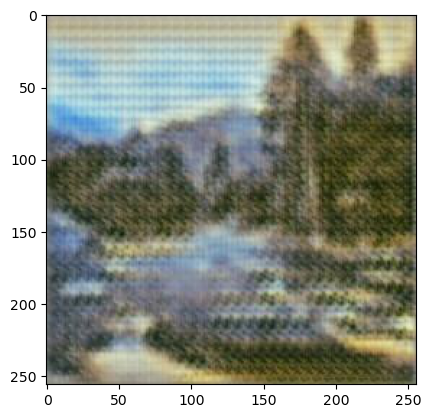

In [107]:
idx =4
img=Image.open(os.path.join(out_directory, f"monet_{idx}.jpg"))
plt.imshow(img)
plt.show()

In [35]:
#Change batch size and rerun model


BATCH_SIZE = 4
epoch_num2= 4

In [57]:
@tf.function
def train_step1(photo_batch,monet_batch):
    with tf.GradientTape(persistent=True) as tape:
        fake_monet = generatorp2m(photo_batch,training=True)
        fake_photo = generatorm2p(monet_batch,training=True)
        
        cycled_photo = generatorm2p(fake_monet, training=True)
        cycled_monet = generatorp2m(fake_photo, training=True)
        
        id_photo = generatorm2p(photo_batch,training=True)
        id_monet = generatorp2m(monet_batch, training= True)
        
        disc_real_m = disc_modelM(monet_batch, training=True)
        disc_real_p = disc_modelP(photo_batch,training= True)
        disc_fake_m = disc_modelM(fake_monet,training=True)
        disc_fake_p = disc_modelP(fake_photo,training=True)
        
        #loss functions
        
        #gen adv loss
        gen_p2ml=gen_loss(disc_fake_m)
        gen_m2pl=gen_loss(disc_fake_p)

        #cycle consistancy loss
        cycle_photo_loss= cycle_loss(photo_batch, cycled_photo)
        cycle_monet_loss= cycle_loss(monet_batch, cycled_monet)

        
        #disc loss
        disc_m_l_val= disc_loss(disc_real_m,disc_fake_m)
        disc_p_l_val= disc_loss(disc_real_p, disc_fake_p)
        
        #identity loss
        
        id_loss_p2m=identity_loss(monet_batch,id_monet)
        id_loss_m2p=identity_loss(photo_batch,id_photo)
        
        # total  gen loss funcitons
        total_p2m_g_l = gen_p2ml + cycle_photo_loss  + cycle_monet_loss + id_loss_p2m
        total_m2p_g_l = gen_m2pl + cycle_photo_loss  + cycle_monet_loss + id_loss_m2p
        
    
    #gradients
    
    gen_p2m_gradients = tape.gradient(total_p2m_g_l,generatorp2m.trainable_variables)
    gen_m2p_gradients = tape.gradient(total_m2p_g_l,generatorm2p.trainable_variables)
    
    disc_m_gradients = tape.gradient(disc_m_l_val, disc_modelM.trainable_variables)
    disc_p_gradients = tape.gradient(disc_p_l_val, disc_modelP.trainable_variables)

    g_p2m_optimizer.apply_gradients(zip(gen_p2m_gradients,generatorp2m.trainable_variables))
    g_m2p_optimizer.apply_gradients(zip(gen_m2p_gradients,generatorm2p.trainable_variables))

    d_p_optimizer.apply_gradients(zip(disc_p_gradients,disc_modelP.trainable_variables))
    d_m_optimizer.apply_gradients(zip(disc_m_gradients,disc_modelM.trainable_variables))

    return disc_m_l_val + disc_p_l_val, total_m2p_g_l + total_p2m_g_l
        

In [58]:
for epoch in range(epoch_num2):
    epoch_d_loss = 0
    epoch_g_loss = 0
    batches =0
    for photo_batch, monet_batch in train_dataset:
        dl, gl = train_step1(photo_batch, monet_batch)
        epoch_d_loss+=dl
        epoch_g_loss+=gl
        batches +=1
    epoch_d_loss /= batches
    epoch_g_loss /= batches
    print(f'epoch{epoch+1}/{epoch_num2} Discriminator Loss: {epoch_d_loss} Generator Loss: {epoch_g_loss}')

2025-11-24 13:10:55.507163: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


epoch1/4 Discriminator Loss: 1.2535992860794067 Generator Loss: 10.492807388305664


2025-11-24 13:21:59.454628: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


epoch2/4 Discriminator Loss: 1.2021825313568115 Generator Loss: 10.076828002929688


2025-11-24 13:32:58.927818: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


epoch3/4 Discriminator Loss: 1.2589794397354126 Generator Loss: 9.224679946899414
epoch4/4 Discriminator Loss: 1.2641655206680298 Generator Loss: 8.682734489440918


2025-11-24 13:44:04.672323: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [59]:
out_directory = "Generated Monet Photos batch 4"
os.makedirs(out_directory,exist_ok=True)
index = 0
for photo_batch in photo_data:
    fake_batch = generatorp2m(photo_batch,training=False)
    fake_batch = (fake_batch+1)*127.5
    fake_batch = tf.clip_by_value(fake_batch,0,255)

    for i in range(fake_batch.shape[0]):
        img= fake_batch[i].numpy().astype("uint8")
        img= Image.fromarray(img)
        img.save(os.path.join(out_directory,f"monet_{index}.jpg"))
        index += 1
shutil.make_archive("imagesbatch4","zip",out_directory)

2025-11-24 13:46:27.606451: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


'/Users/kevinwalker/Downloads/imagesbatch4.zip'

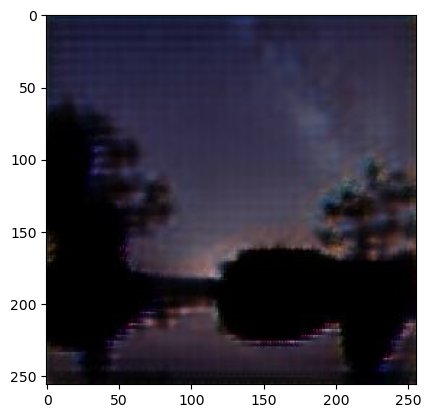

In [60]:
idx =505
img=Image.open(os.path.join(out_directory, f"monet_{idx}.jpg"))
plt.imshow(img)
plt.show()

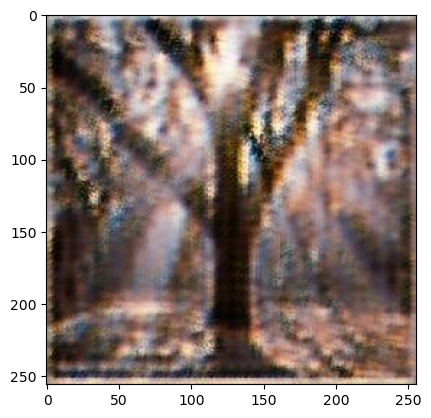

In [61]:
idx =5687
img=Image.open(os.path.join(out_directory, f"monet_{idx}.jpg"))
plt.imshow(img)
plt.show()